# Pathway Enrichment of LR loadings

<span style='color:red'> Need to read through markdowns and update appropriately for R

Cell-cell communication inference from single-cell data provides unprecedented insights into the molecular mechanisms underlying cell-cell communication. In particular, it enables the capture of CCC interactions at a systems level, which is not possible with traditional approaches. However, as the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, as done in other omics studies, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Pathway enrichment thus serves two purposes; it reduces the dimensionality of the inferred interactions, and also provides a biological summary of the inferred interactions.

In this tutorial, we will show how to use `liana` to perform classical gene set enrichment analysis using `GSEA` with `KEGG Pathways`, and also we will use perform a footprint enrichment analysis using a `multi-variate linear model` with the PROGENy pathway resource. We will use the [`GSEAPY`](https://gseapy.readthedocs.io/en/latest/) and [`decoupler-py`](https://decoupler-py.readthedocs.io/en/latest) packages to perform these analyses.

In [76]:
library(liana, quietly = T)

library(decoupleR, quietly = T)
library(textshape, quietly = T)
library(dplyr, quietly = T)
library(reshape2, quietly = T)
library(tibble, quietly = T)

library(stringr, quietly = T)

library(ggplot2, quietly = T)

library(reticulate, quietly = T)
c2c <- reticulate::import(module = "cell2cell", as="c2c")

## Directories

In [15]:
output_folder <- '../../data/tc2c-outputs/'
data.path <- '/data/hratch/ccc_protocols/interim/' # REPLACE

## Load Data

**Open the loadings obtained from the tensor factorization**

In [3]:
covid_data <- readRDS(paste0(data.path, 'covid_data_sce.rds'))
factors <- liana::get_c2c_factors(sce = covid_data,
                            sample_col = "sample_new",
                            group_col = "condition")

**Load list of LR pairs used as reference to [run LIANA](./02-Infer-Communication-Scores.ipynb)**

In [32]:
lr_pairs <- liana::select_resource('Consensus')
lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
head(lr_pairs)

ligand,receptor
<chr>,<chr>
LGALS9,PTPRC
LGALS9,MET
LGALS9,CD44
LGALS9,LRP1
LGALS9,CD47
LGALS9,PTPRK


**Generate a list with the LR pair names**

GSEA was originally designed to work with list of genes. Here we are using ligand-receptor pairs, so instead of using Gene Sets we need to build our LR-gene sets. This list is a first step to build the LR-gene sets.

In [43]:
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))

## Gene Set Enrichment Analysis

In this case, we will run the PreRank method of GSEA since our LR pairs are pre-ranked based on their loadings in each factor obtained by Tensor-cell2cell.

### Generate LR-gene set for running GSEA

`cell2cell` includes some resources associated with the Gene sets employed in GSEA. It includes annotations of GO Terms (BP), KEGG, and Reactome, for human and mouse.

**First, specify which organism and annotation DB to use**

In [45]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'KEGG' # KEGG Pathways

**Generate the LR-gene set that will be used for running GSEA**

In [46]:
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                                complex_sep='_', # Separation symbol of the genes in the protein complex
                                  lr_sep='^', # Separation symbol between a ligand and a receptor complex
                                  organism=organism,
                                  pathwaydb=pathwaydb,
                                  readable_name=TRUE)

### Extract LR loadings for each factor

In [62]:
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

### Run GSEA

This external function implemented in `cell2cell` builds upon the function `gseapy.prerank()`.

All outputs will be saved in the `output_folder`. Make sure that this path exist before running this function.

In [82]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=output_folder,
                               weight=as.integer(1),
                               min_size=as.integer(15),
                               permutations=as.integer(999),
                               processes=as.integer(6),
                               random_state=as.integer(6),
                               significance_threshold=as.numeric(0.05)
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

### Visualization

We can use the `pvals` and `scores`outputs to visualize the results as a Dot Plot:

In [214]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}


Using Annotation as id variables

Using Annotation as id variables



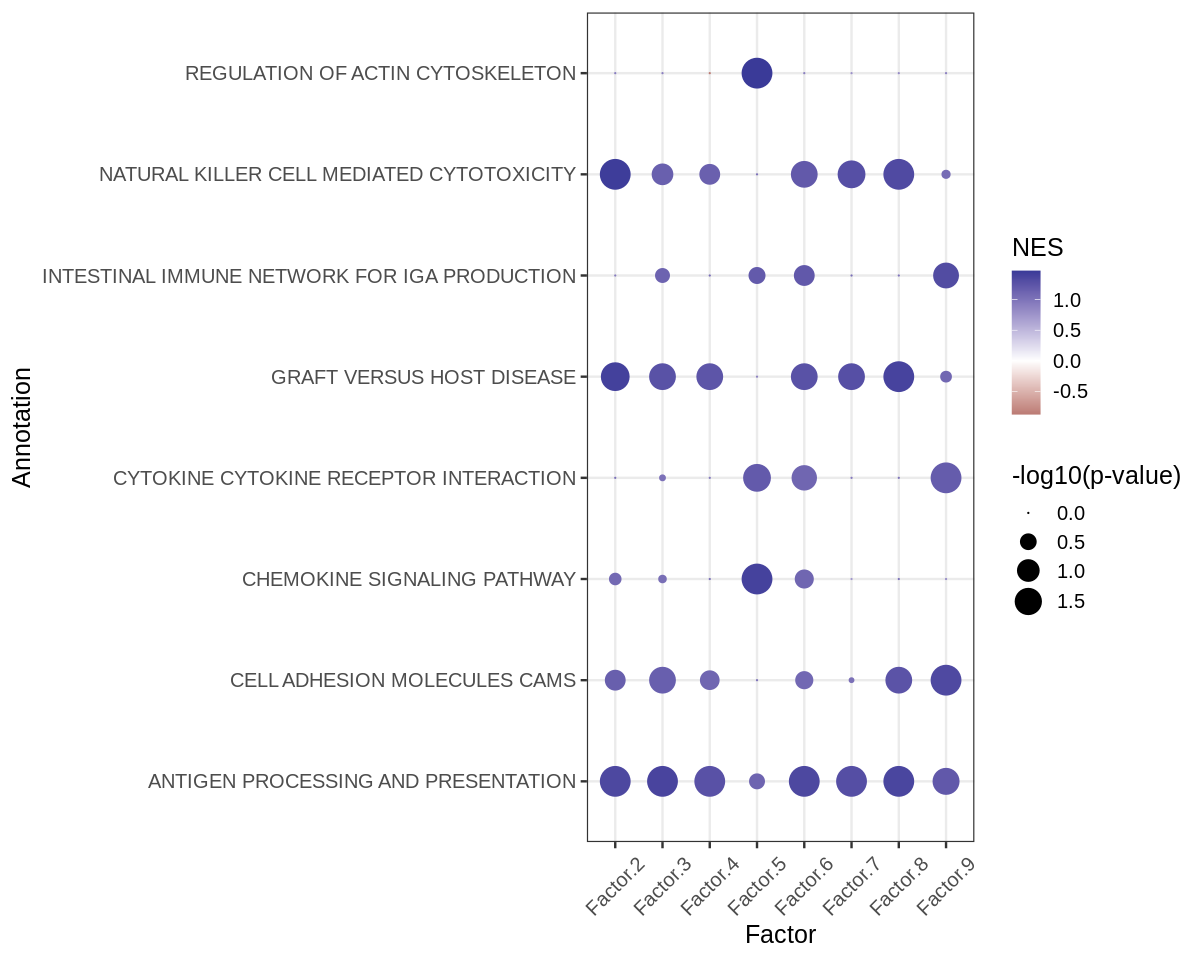

In [215]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

**Similarly, we can use gsea_df to easily see the Enriched Pathways**

In [220]:
gsea_df<-gsea_res$gsea_df
gsea_df[gsea_df[['Adj. P-value']] < 0.05 & gsea_df[['NES']] > 0, ]

,Factor,Term,NES,P-value,Adj. P-value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0,Factor.2,NATURAL KILLER CELL MEDIATED CYTOTOXICITY,1.450106,0.001000000,0.01109912
1,Factor.2,GRAFT VERSUS HOST DISEASE,1.411528,0.002002002,0.02059202
2,Factor.2,ANTIGEN PROCESSING AND PRESENTATION,1.355263,0.001000000,0.01109912
16,Factor.3,ANTIGEN PROCESSING AND PRESENTATION,1.382841,0.001000000,0.01109912
17,Factor.3,GRAFT VERSUS HOST DISEASE,1.272605,0.006006006,0.03603604
18,Factor.3,CELL ADHESION MOLECULES CAMS,1.164029,0.006006006,0.03603604
32,Factor.4,ANTIGEN PROCESSING AND PRESENTATION,1.276910,0.001000000,0.01109912
33,Factor.4,GRAFT VERSUS HOST DISEASE,1.248877,0.005005005,0.03603604
48,Factor.5,REGULATION OF ACTIN CYTOSKELETON,1.471759,0.001002004,0.01109912


**And Depleted Pathways**

In [221]:
gsea_df[gsea_df[['Adj. P-value']] < 0.05 & gsea_df[['NES']] < 0, ]

Factor,Term,NES,P-value,Adj. P-value
<chr>,<chr>,<dbl>,<dbl>,<dbl>


## Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). This is particularly useful when working with transcriptomics data, as it allows to identify the genes that are regulated by a biological process, instead of the genes that are part of the process. In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets.

To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupleR` package to perform this analysis.

###  load the PROGENy pathway resource:

In [4]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'human', top=5000) %>%
    dplyr::select(-p_value)

Now we will use the PROGENy genesets to assign pathways and weights to the ligand-receptor pairs in liana's consensus resource. Specifically, we will use the weighted bipartite networks from PROGENy, where the weight represents the importance of the genes to a given geneset, and assign a weight to each ligand-receptor interaction, based on the mean of the weights of the proteins in that ligand-receptor interaction. We keep only ligand-receptor weights only if all the protein in the ligand-receptor interaction are present for a given pathway, and are sign-coherent.

In [5]:
# convert to LR sets
progeny_lr <- liana::generate_lr_geneset(sce = covid_data,
                                  resource = progeny)
head(progeny_lr)

lr,set,mor
<chr>,<chr>,<dbl>
ACTR2^LDLR,EGFR,1.1326914
ADAM10^CADM1,MAPK,-1.0350601
ADAM10^GPNMB,EGFR,-1.9858320
ADAM10^GPNMB,MAPK,-2.7904170
ADAM10^NOTCH1,EGFR,-0.9249343
ADAM10^NOTCH1,MAPK,-0.9250379


### Run footprint enrichment analysis

We will now use the `decoupleR` package to perform the analysis.

In [6]:
# interaction loadings to matrix
mat <- factors$interactions %>%
    textshape::column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

### Visualize Results

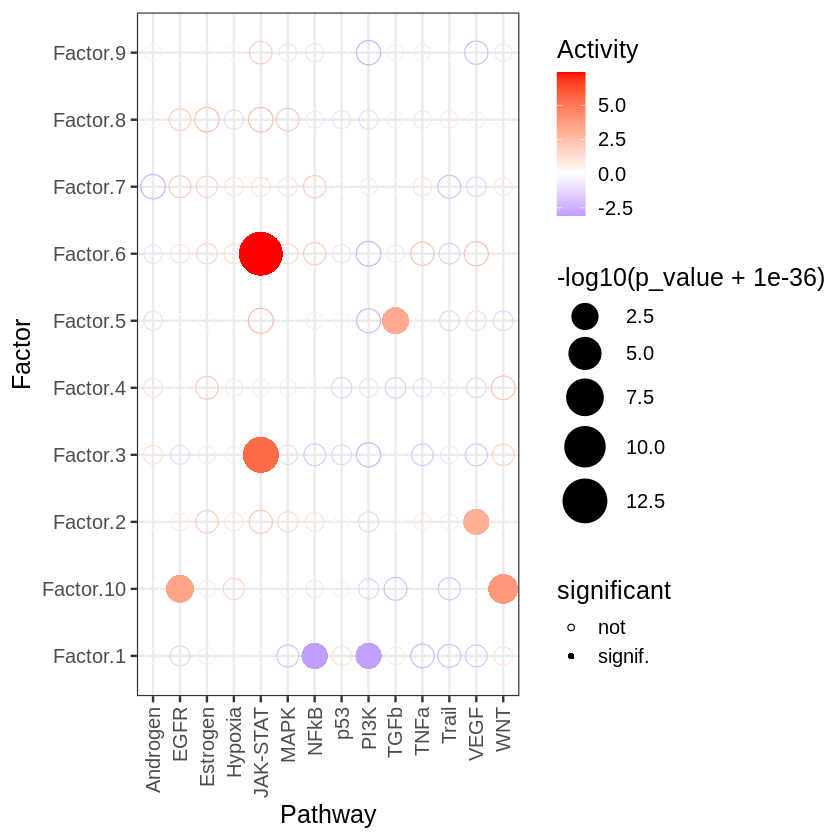

In [7]:
res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.05, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

Let's zoom in on Factor 8, which is associated with COVID-19 cases.

<span style='color:red'> No filtering for significance, because no pathways are significant...

In [8]:
selected_factor = 'Factor.8'

In [9]:
# filter for factor of interest and recalculate adjusted pvals
res.factor<-res[(res$condition == selected_factor), ] %>% 
                mutate(p_adj = p.adjust(p_value, method = "fdr"))
# res.factor<-res.factor[res.factor$p_adj <= 0.5, ]
res.factor<-res.factor[order(res.factor$score, decreasing = TRUE), ]
res.factor[['source']] <- factor(res.factor[['source']], levels=res.factor$source)
head(res.factor)

statistic,source,condition,score,p_value,p_adj
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
ulm,Estrogen,Factor.8,2.5848660,0.009840866,0.07161161
ulm,JAK-STAT,Factor.8,2.5713937,0.010230230,0.07161161
ulm,MAPK,Factor.8,2.1543483,0.031380998,0.14644466
ulm,EGFR,Factor.8,1.8518872,0.064249916,0.22487470
ulm,Trail,Factor.8,0.8076129,0.419448978,0.61941032
ulm,Androgen,Factor.8,0.5483536,0.583535491,0.64123458


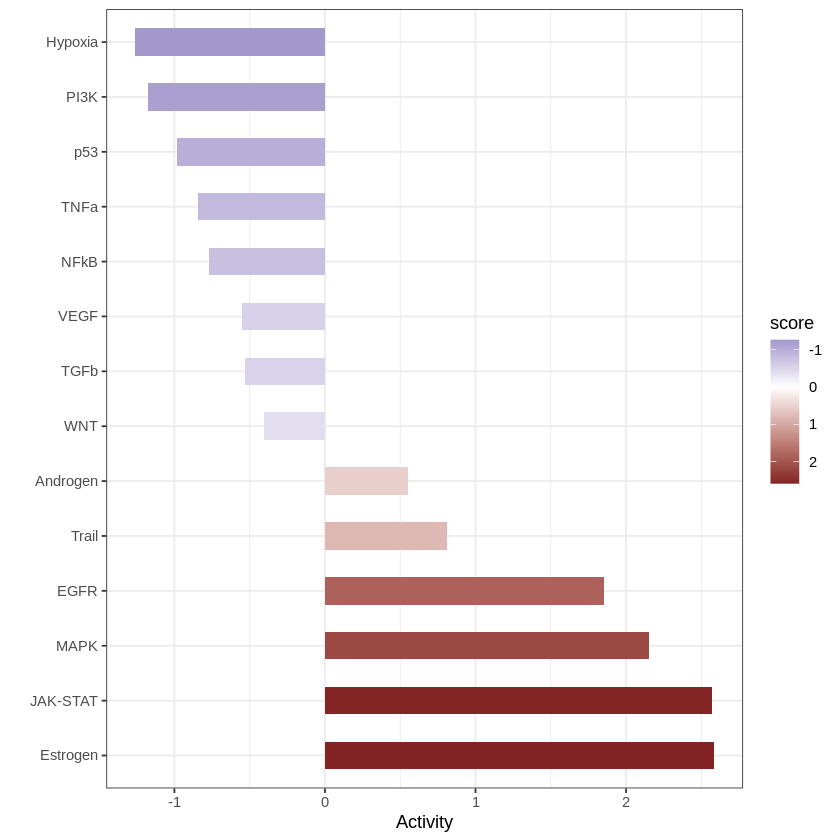

In [10]:
ggplot(data=res.factor, aes(x=score, y=source, fill = score)) +
  geom_bar(stat="identity", width=0.5) + theme_bw() + scale_fill_gradient2(trans = 'reverse') + 
ylab('') + xlab('Activity')

From the plots above, we can see that the JAK-STAT pathway is highly active in Factor 8. This is also concordant with the KEGG pathways associated with the chemokine and cytotoxic response from the analysis with GSEA above. Indeed, the tensor decomposition results indicate that NKs and T cells are the main sender cells in this factor. So, let's see which ligand-receptor pairs are enriched in this pathway.

In [21]:
pathway = 'JAK-STAT'

# loadings to long format
lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only NFkB pathway


lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == 'NFkB' and Factor == '{}'".format(selected_factor))
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)
lr_loadings_long.head()

,interaction,Factor,Loadings,source,weight,sign,relevant_interactions
171,ADAM17^ITGA5,Factor 6,1.756948e-39,NFkB,1.961245,positive,None
226,ADAM17^MUC1,Factor 6,8.227501e-05,NFkB,1.680033,positive,None
260,ADAM17^RHBDF2,Factor 6,0.000000e+00,NFkB,2.274298,positive,None
311,ADM^ACKR3,Factor 6,1.704504e-02,NFkB,3.507252,positive,None
335,ADM^GPR84,Factor 6,6.204670e-02,NFkB,5.392048,positive,ADM^GPR84


#### plot the loadings for Factor 6 and weights of the NFkB pathway

Warning message in left_join(., progeny_lr, by = "lr"):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 8 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this
  warning.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


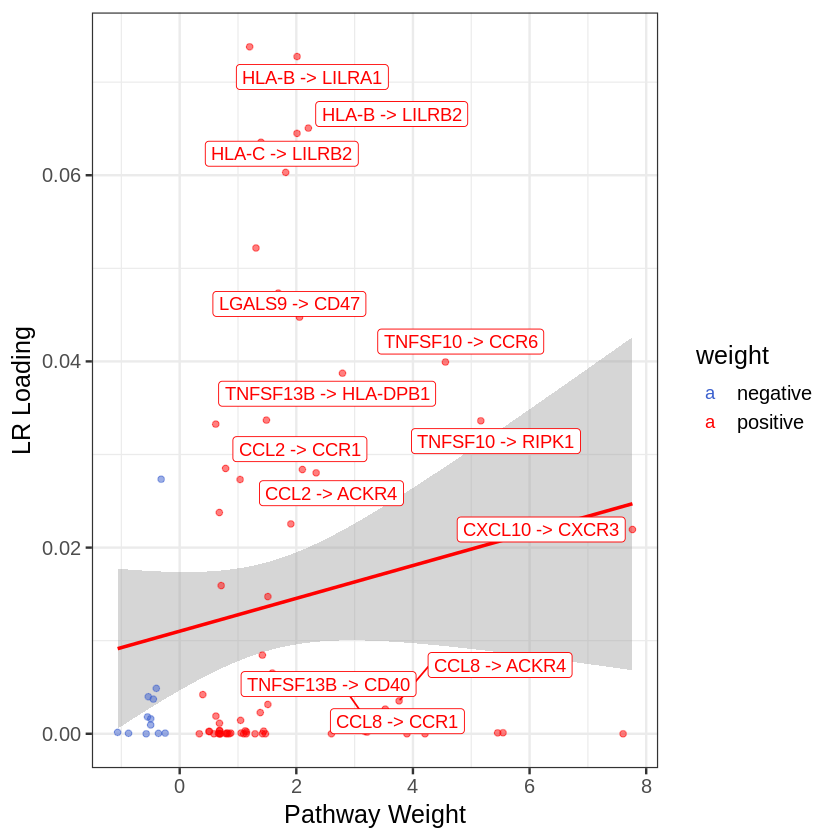

In [13]:
pathway = 'JAK-STAT'
# Plot LRs associated with Estrogen
lrs <-  factors$interactions %>%
  left_join(progeny_lr, by="lr") %>%
  filter(set==pathway) %>%
  select(lr, set, mor, loading = Factor.4) %>%
  mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
  mutate(weight = if_else(mor >= 0, "positive", "negative"))
lrs %>%
  # only label those that are > x
  mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
  ggplot(aes(x=mor, y=loading, colour=weight)) +
  # label only top 20
  stat_smooth(method = "lm", col = "red") +
  geom_point(alpha = 0.5) + 
  ggrepel::geom_label_repel(aes(label = lr)) +
  theme_bw(base_size = 15) +
  scale_colour_manual(values = c("royalblue3", "red")) +
  labs(x="Pathway Weight", y="LR Loading")

Here, we can see that for example the `C3 -> IFITM1` and `VEGFA -> CD44` are interactions found with high importances in the NFkB pathway, and high loadings. Also IFITM1 is involved in restricting viral infection (https://doi.org/10.15252/embj.2020106501), which in this case could represent the immune response controling the SARS-CoV-2 infection.